# Analyzing Contextualized Models

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes

X, Y = load_diabetes(return_X_y=True, as_frame=True)
Y = np.expand_dims(Y.values, axis=-1)
C = X[['age', 'sex', 'bmi']]
X.drop(['age', 'sex', 'bmi'], axis=1, inplace=True)

seed = 1
C_train, C_test, X_train, X_test, Y_train, Y_test = train_test_split(C, X, Y, test_size=0.20, random_state=seed)

# Save/load the trained model.

In [2]:
from contextualized.utils import load

save_path = './easy_demo_model.pt'
model = load(save_path)

# Inspect the model predictions.

We can use standard plotting tools to inspect the model predictions.

In [3]:
%%capture
predicted_probs = model.predict(C.values, X.values)[:, 0]

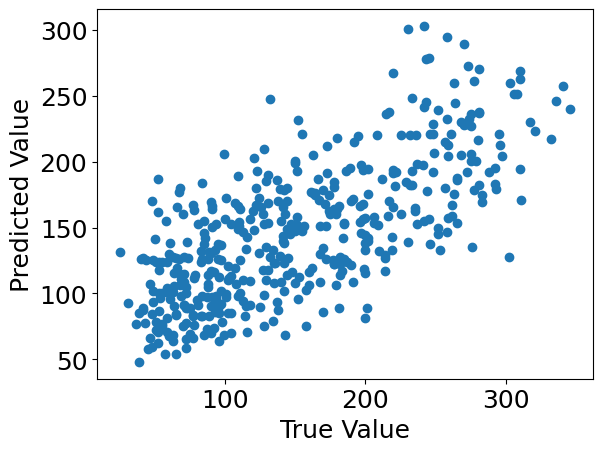

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

plt.scatter(Y[:, 0], predicted_probs)
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.show()

# Check how the individual bootstrap models learned.

Since we're bootstrapping for robustness, we can also access individual bootstrap runs with the `individual_preds` keyword to get confidence intervals.

In [5]:
%%capture
model_preds = model.predict(C.values, X.values, individual_preds=True)
model_preds.shape  # (n_bootstraps, n_samples, n_outputs)

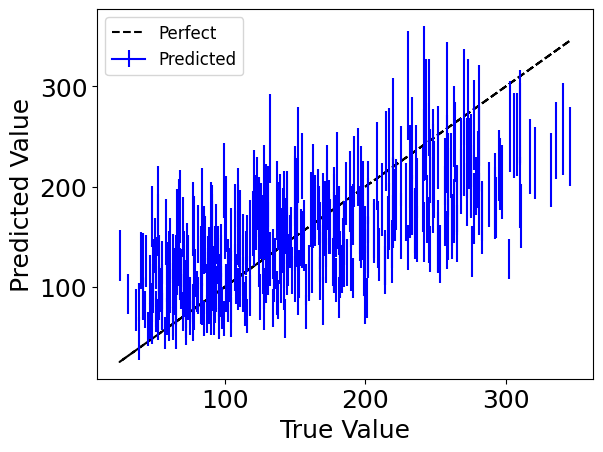

In [6]:
plt.plot(Y[:, 0], Y[:, 0], color='black', linestyle='--', label='Perfect')
plt.errorbar(Y[0, 0], np.mean(model_preds[:, 0, 0], axis=0),
                yerr=2*np.std(model_preds[:, 0, 0], axis=0), color='blue',
            label='Predicted')
for i in range(model_preds.shape[1]):
    plt.errorbar(Y[i, 0], np.mean(model_preds[:, i, 0], axis=0),
                yerr=2*np.std(model_preds[:, i, 0], axis=0), color='blue')
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.legend(fontsize=12)
plt.show()

# Check what effects the models learned.

In [7]:
# First, to get a sense of how the models are clustered, let's embed 
# the model parameters in a 2-D space and visualize them.

In [8]:
%%capture
betas, mus = model.predict_params(C.values, individual_preds=False)
betas.shape # (n_samples, n_outputs, n_predictors)
mus.shape  # (n_samples, n_outputs)

# Betas are shape:
# (n_samples, n_outputs, n_predictors)
# Let's squeeze out the n_outputs axis since we only have 1 output in this example.
betas = np.squeeze(betas)

# Any embedding method could be used; here we will use UMAP.
from umap import UMAP
um = UMAP(n_neighbors=5)
model_reps = um.fit_transform(betas)

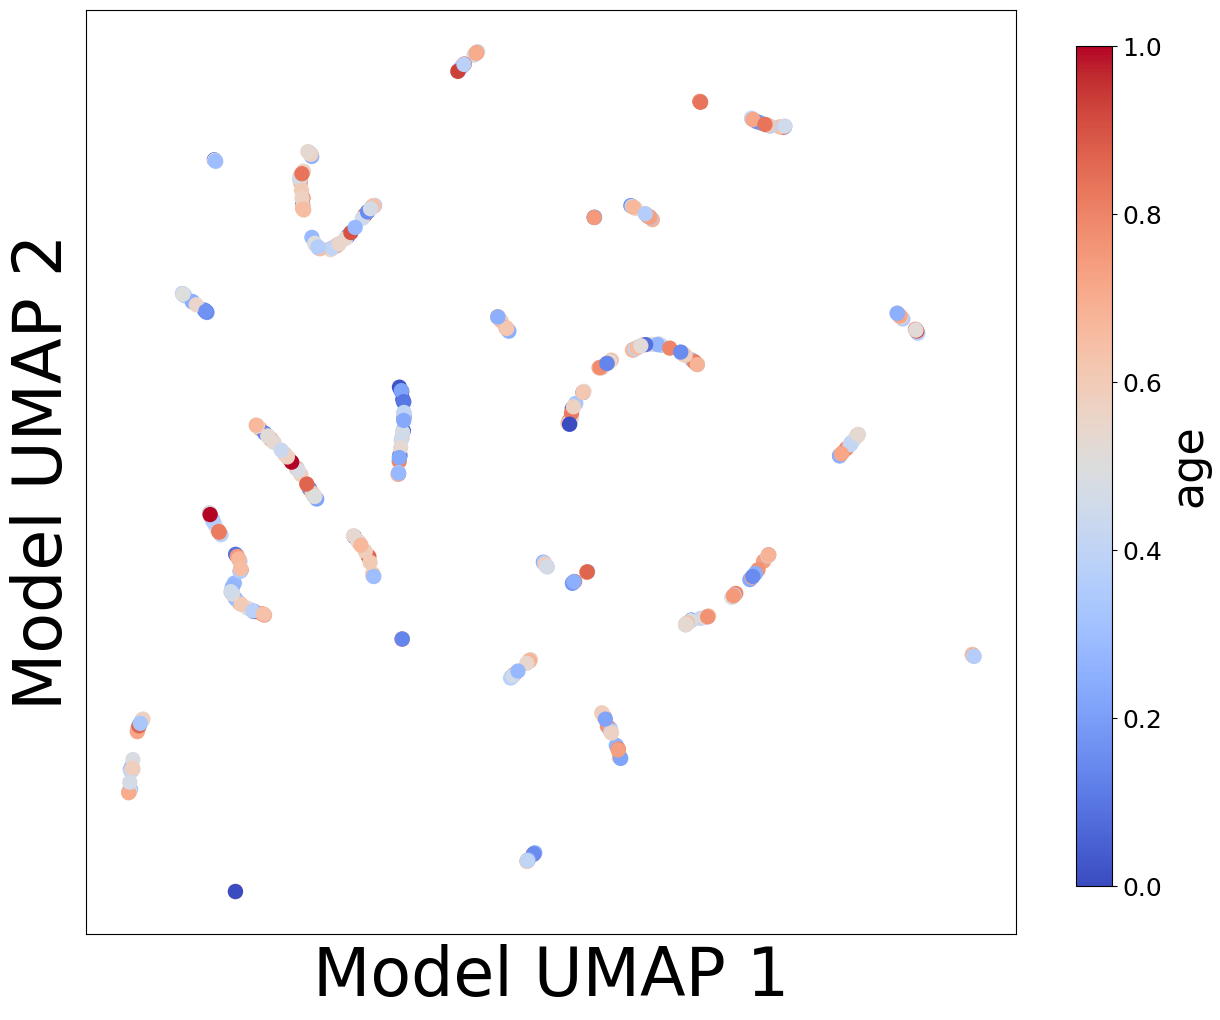

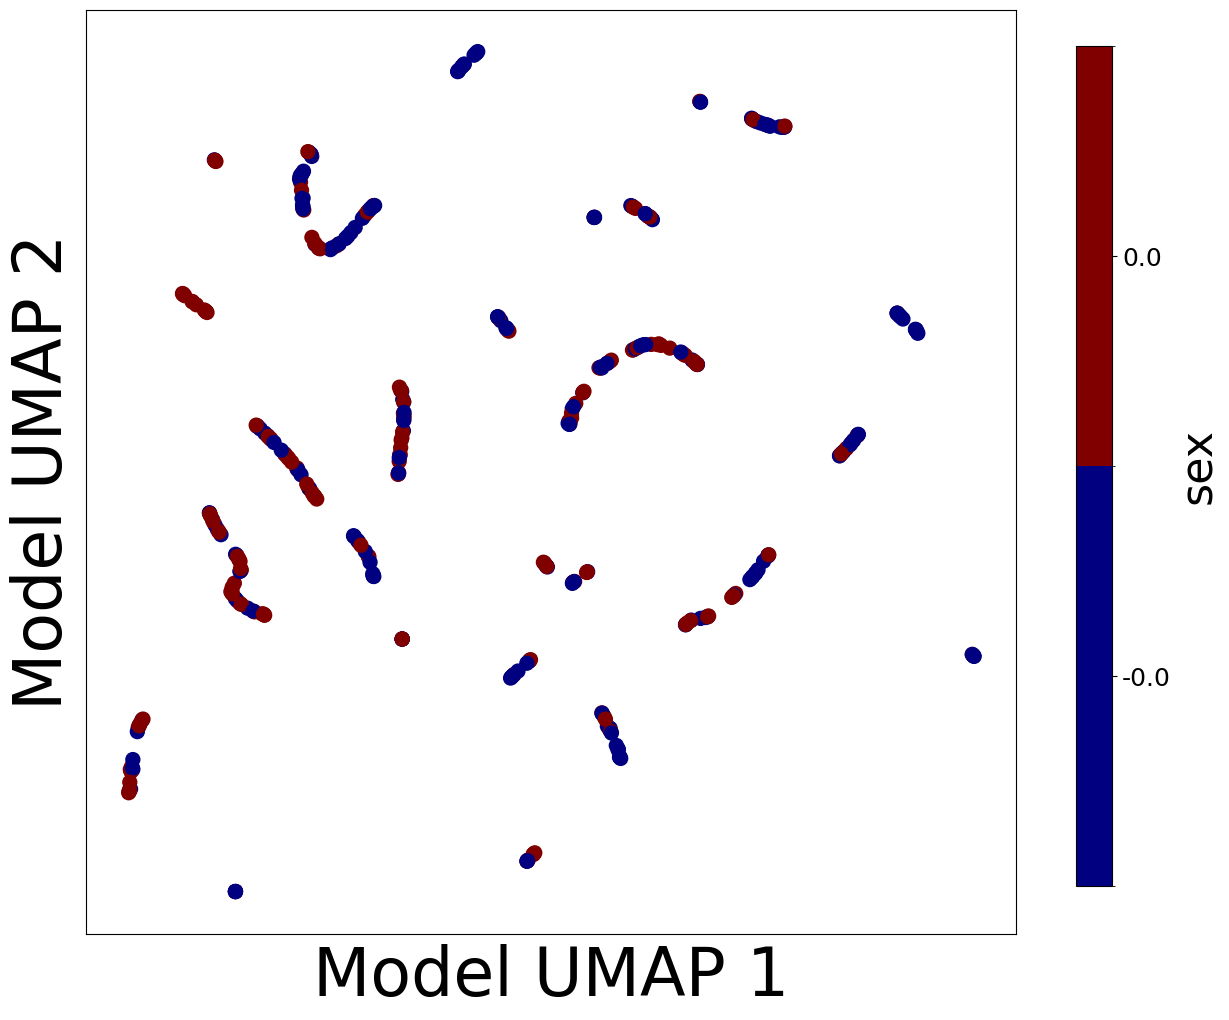

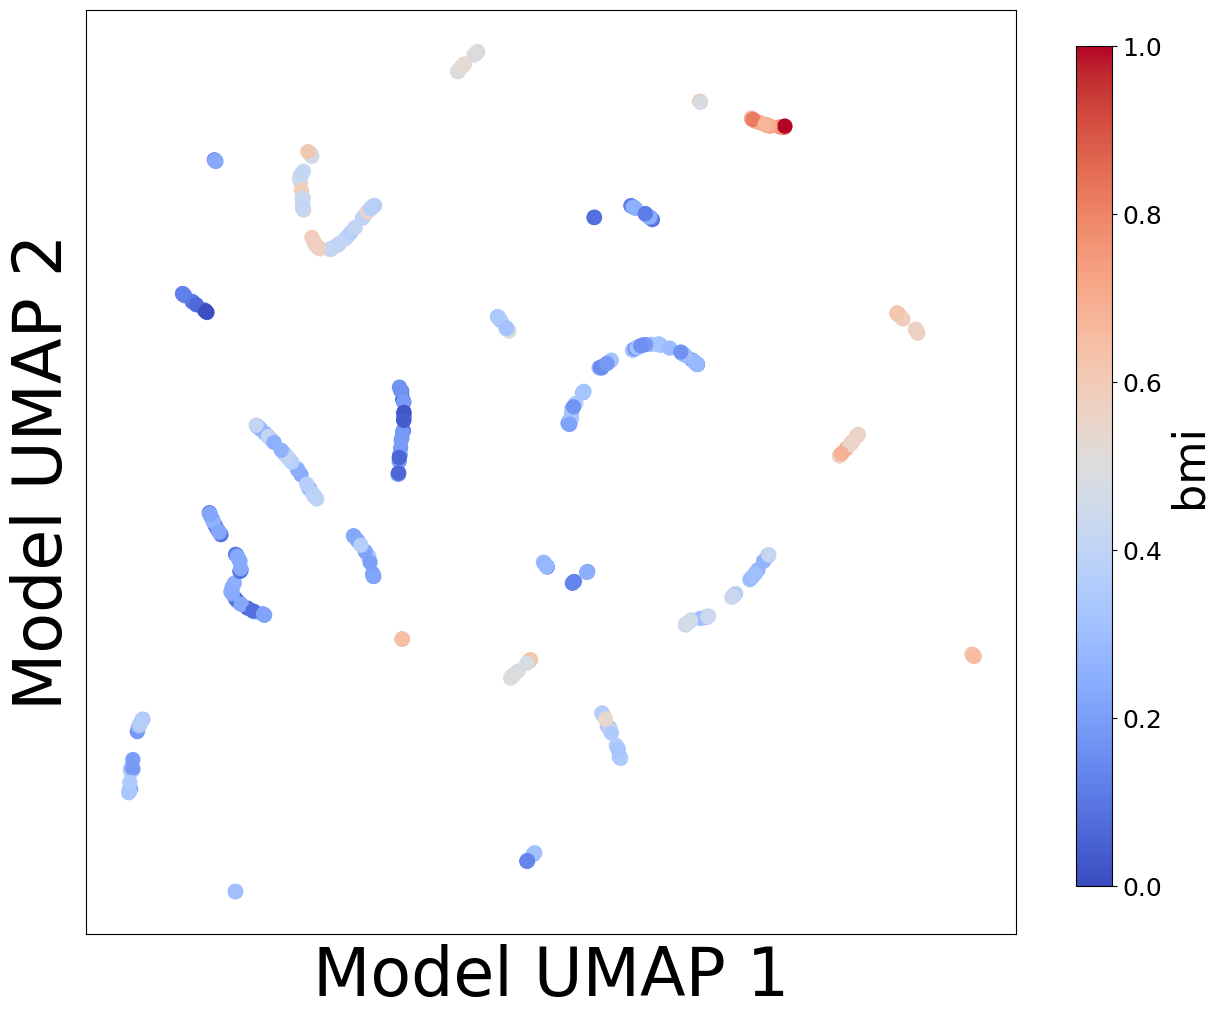

In [9]:
# A simple helper function is provided in the analysis toolkit for plotting embeddings.
from contextualized.analysis.embeddings import plot_embedding_for_all_covars
plot_embedding_for_all_covars(model_reps, C, xlabel='Model UMAP 1', ylabel='Model UMAP 2')

There are three types of effects in a contextualized model:
- Homogeneous Context Effects:
    - $f(C)$
- Homogeneous Predictor Effects:
    - $\beta X$
- Heterogeneous Predictor Effects:
    - $g(C)X$
    - These are effects of predictors which are modulated by context 

Helper analysis tools are provided to analyze each of these effects by:
- getting the values of the effects for a domain of context
- plotting the values of the effect for a domain of context
- calculating p-values of the effect for a domain of context

In [10]:
from contextualized.analysis.effects import (
    get_homogeneous_context_effects,
    get_homogeneous_predictor_effects,
    get_heterogeneous_predictor_effects,
    plot_homogeneous_context_effects,
    plot_homogeneous_predictor_effects,
    plot_heterogeneous_predictor_effects,
)

from contextualized.analysis.pvals import (
    calc_homogeneous_context_effects_pvals,
    calc_homogeneous_predictor_effects_pvals,
    calc_heterogeneous_predictor_effects_pvals
)

## What are the homogeneous predictors of diabetes progression?

#### First, we can see the homogeneous effects of context.

/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

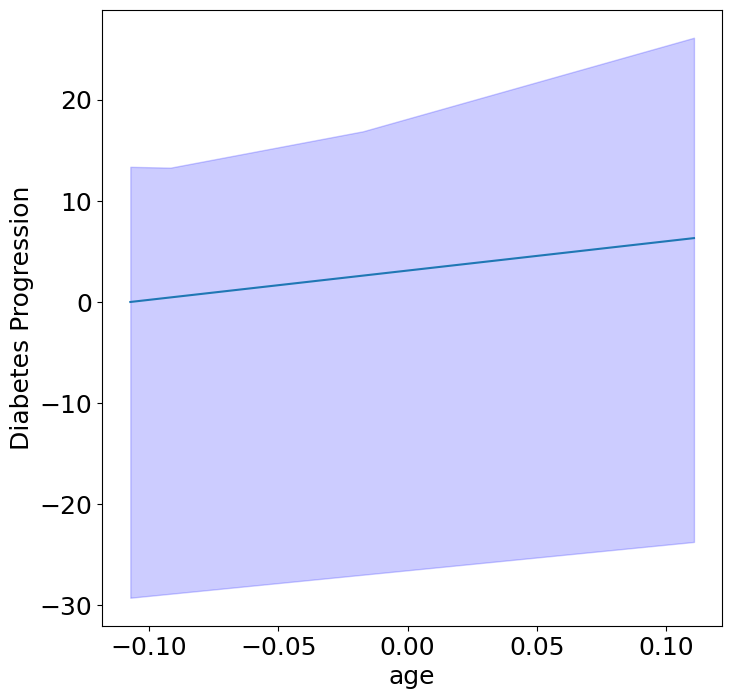

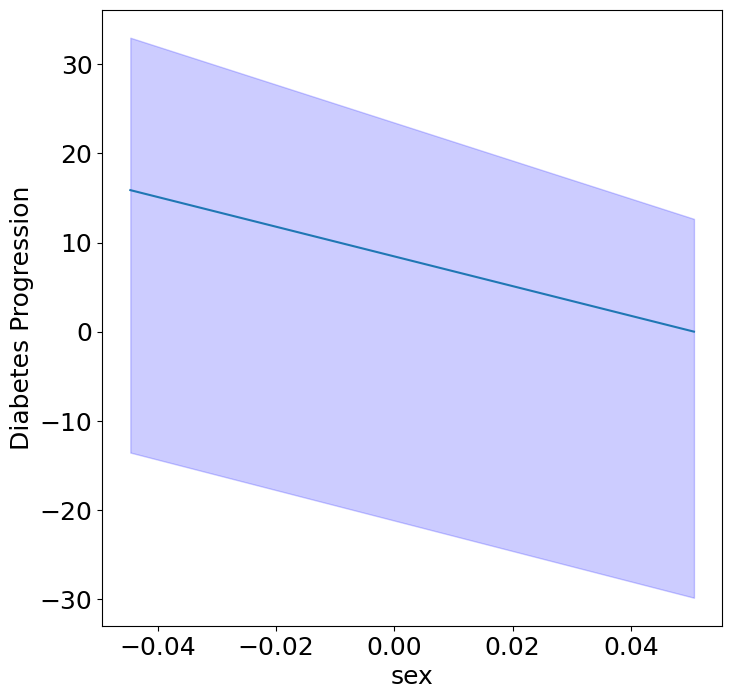

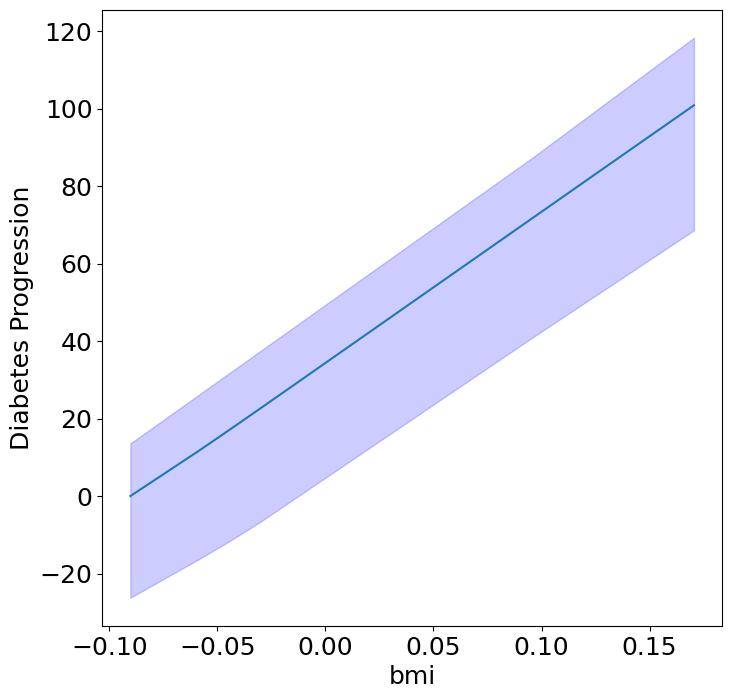

In [11]:
plot_homogeneous_context_effects(
    model, C, classification=False,
    ylabel="Diabetes Progression", verbose=False)

In [12]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
homogeneous_context_pvals = calc_homogeneous_context_effects_pvals(model, C)
context_pvals = pd.DataFrame(np.array([
   [C.columns[i], pval[0]] for i, pval in enumerate(homogeneous_context_pvals)
]), columns=["Context Variable", "p-value"])

In [13]:
context_pvals
# Notice that the p-values are calculated from bootstrap resampling,
# so they are limited by the number of bootstraps used.
# Caution: using more bootstraps could artificially inflate confidence.

,Context Variable,p-value
0,age,0.2727272727272727
1,sex,0.09090909090909091
2,bmi,0.09090909090909091


#### Second, we can see the homogeneous effects of the predictors.

/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

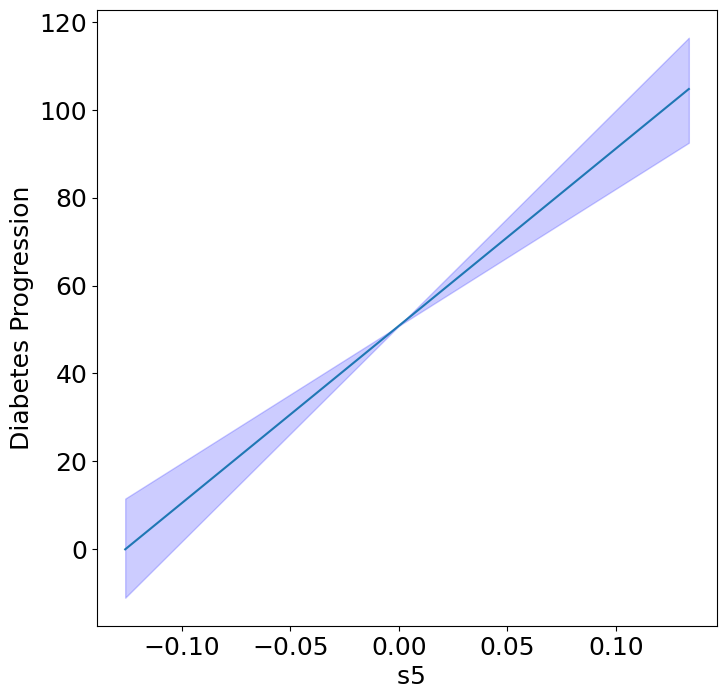

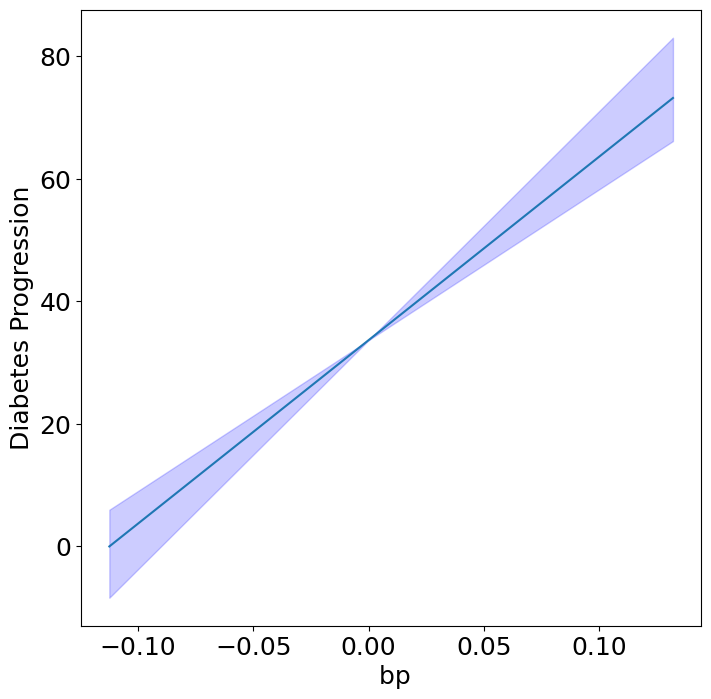

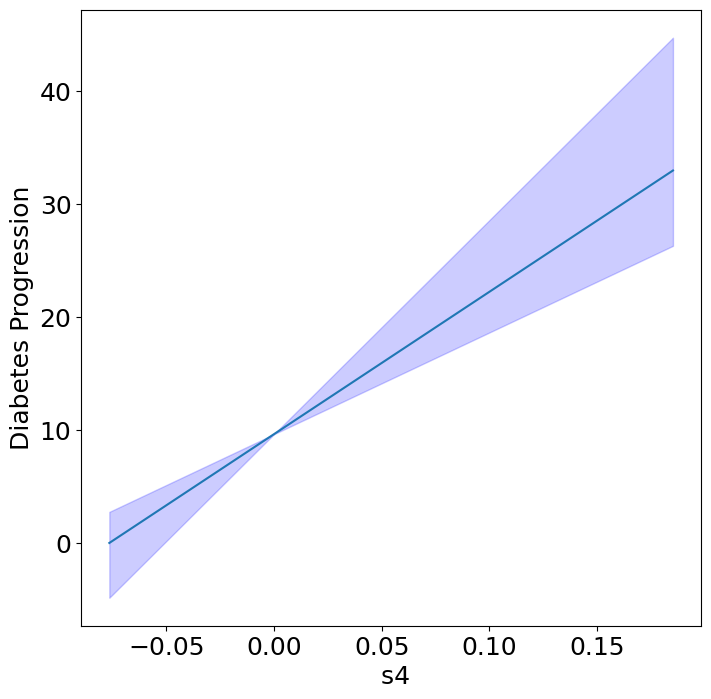

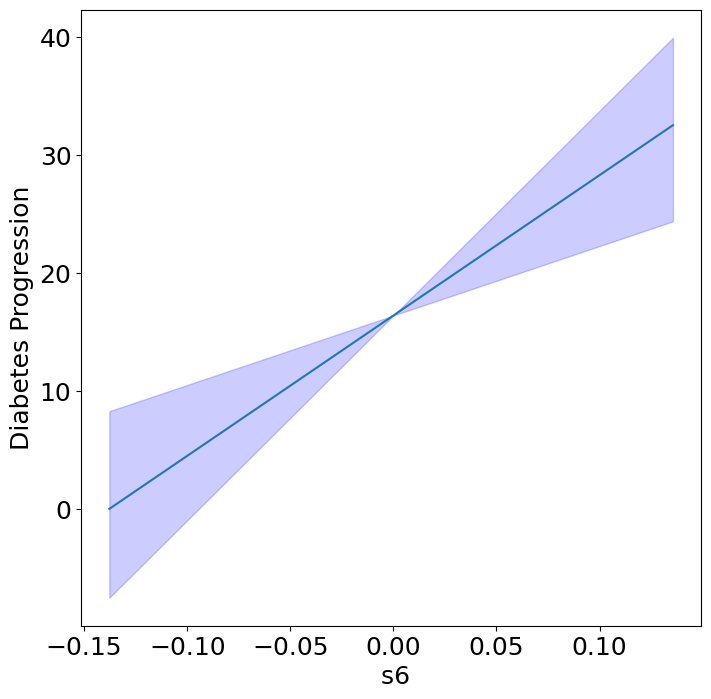

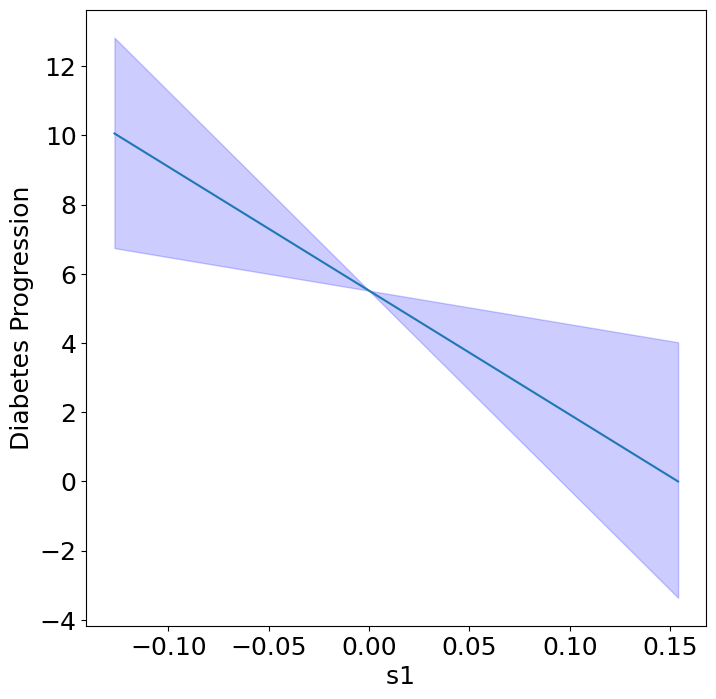

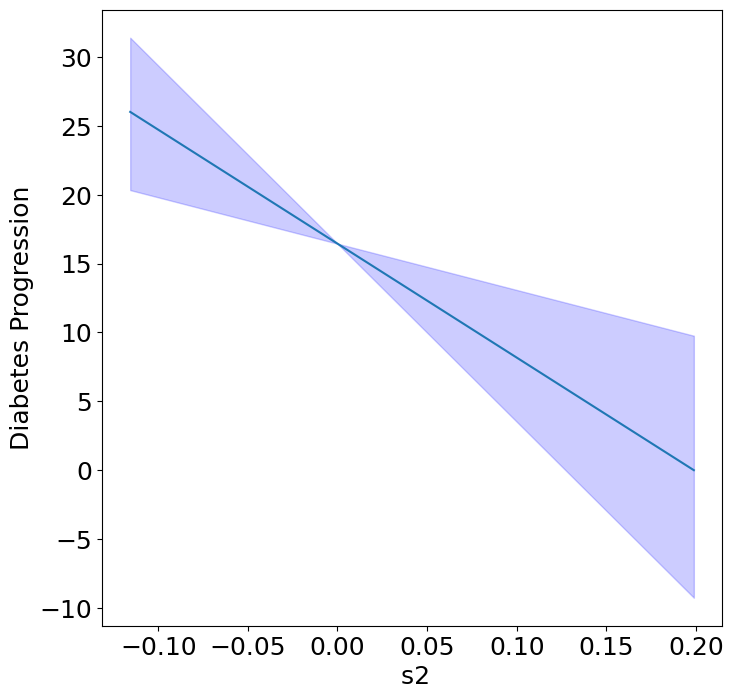

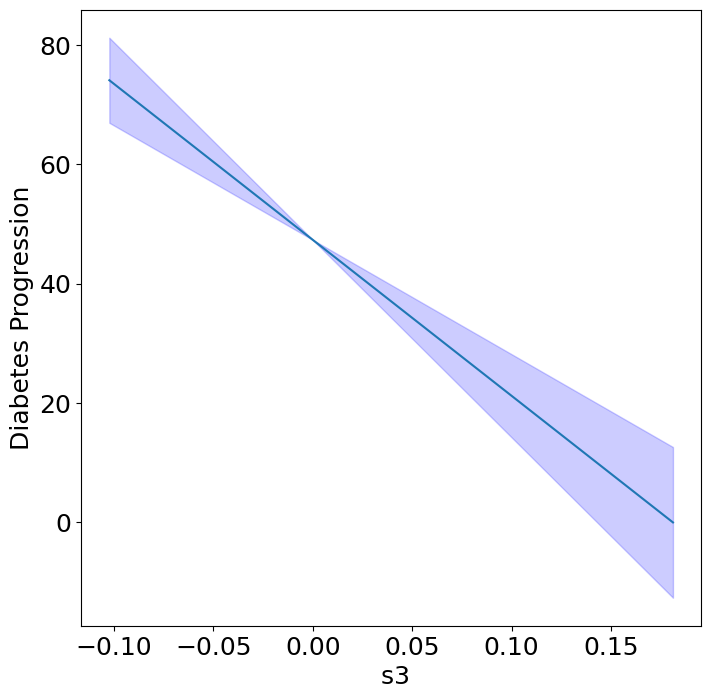

In [14]:
plot_homogeneous_predictor_effects(
    model, C, X,
    ylabel="Diabetes Progression",
    classification=False)

In [15]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
homogeneous_predictor_pvals = calc_homogeneous_predictor_effects_pvals(model, C)
predictor_pvals = pd.DataFrame(np.array([
   [X.columns[i], pval[0]] for i, pval in enumerate(homogeneous_predictor_pvals)
]), columns=["Predictor", "p-value"])

In [16]:
predictor_pvals

,Predictor,p-value
0,bp,0.09090909090909091
1,s1,0.09090909090909091
2,s2,0.09090909090909091
3,s3,0.09090909090909091
4,s4,0.09090909090909091
5,s5,0.09090909090909091
6,s6,0.09090909090909091


#### Third, we can see the heterogeneous effects (effects of predictors than change based on context).

Generating datapoints for visualization by assuming the encoder is
            an additive model and thus doesn't require sampling on a manifold.
            If the encoder has interactions, please supply C_vis so that we
            can visualize these effects on the correct data manifold.


/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

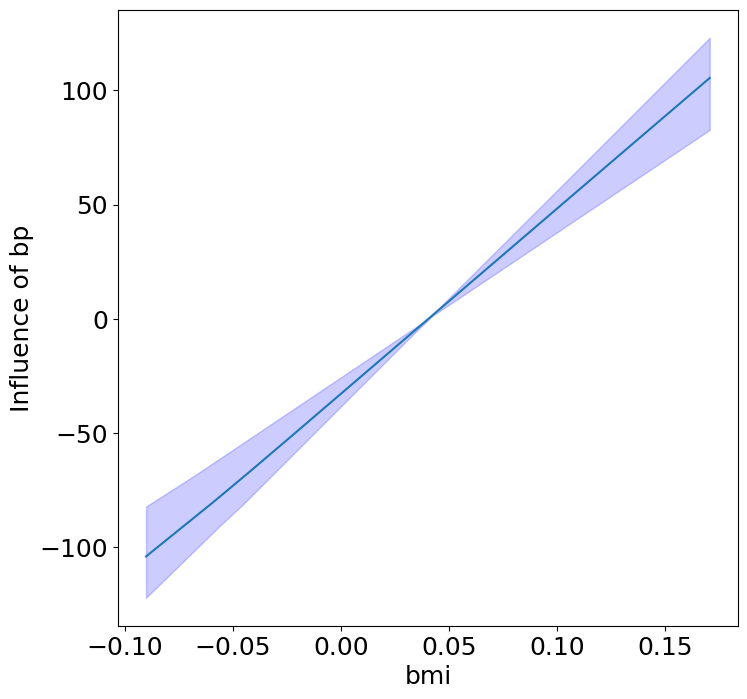

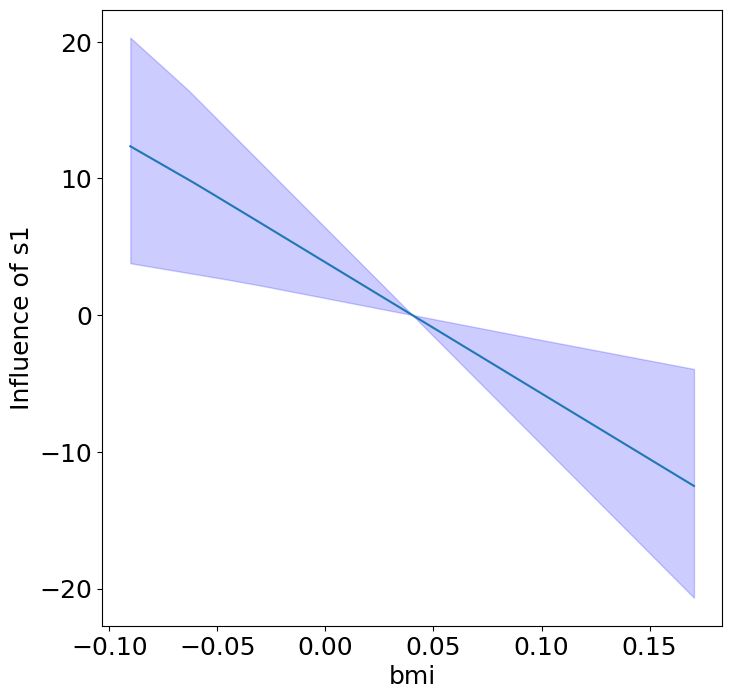

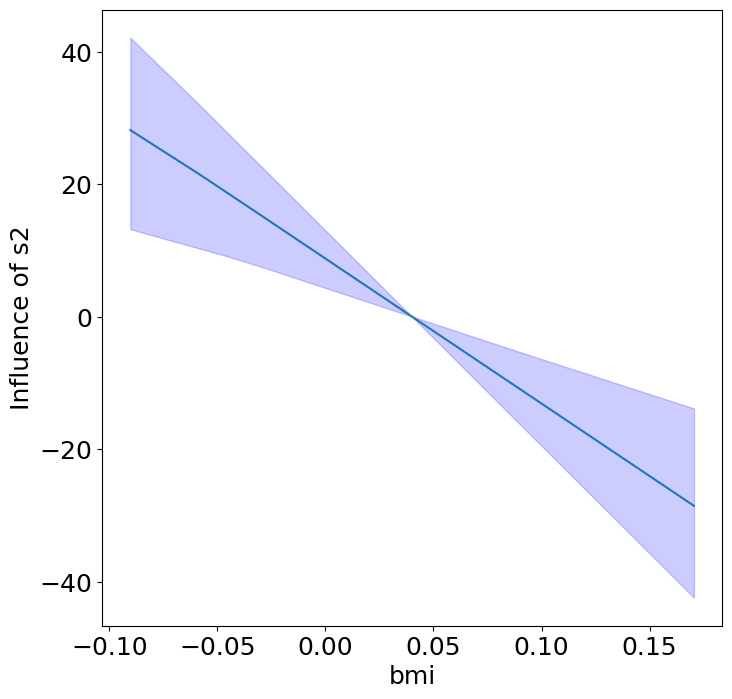

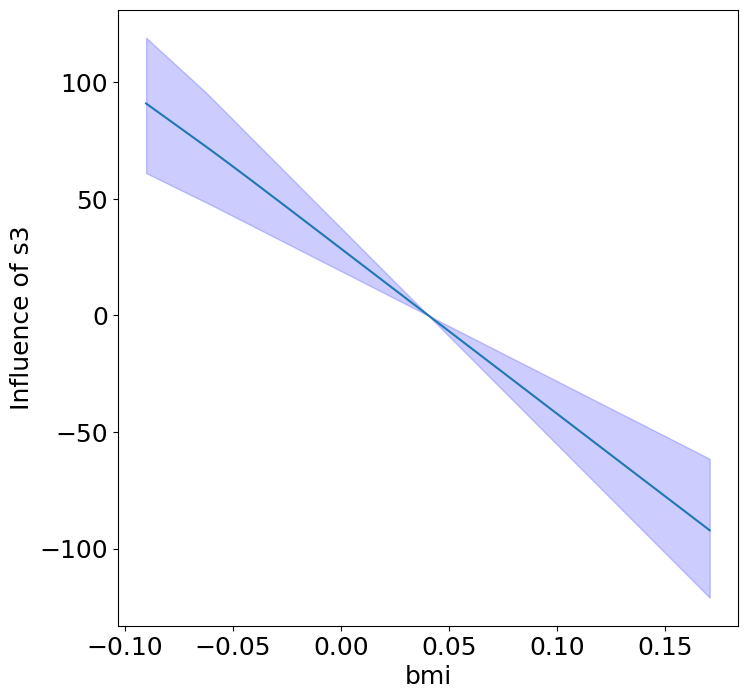

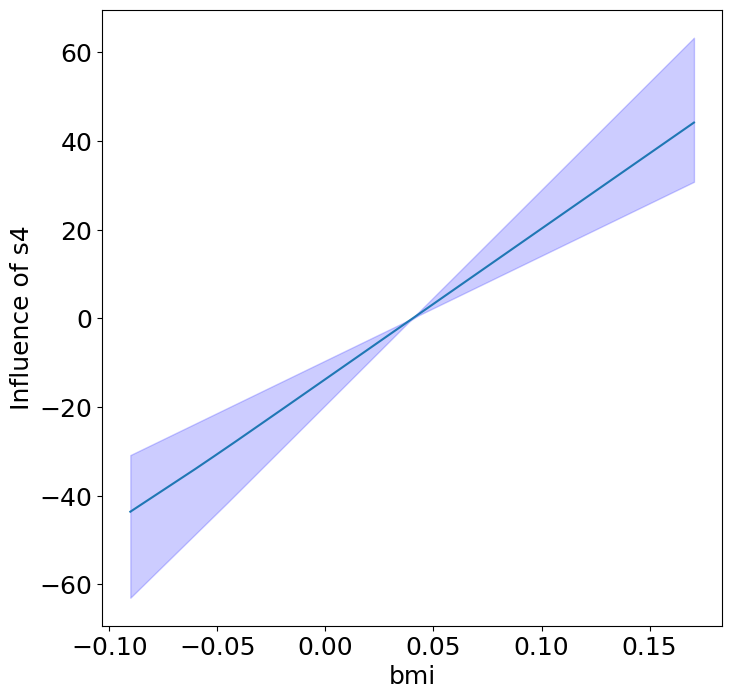

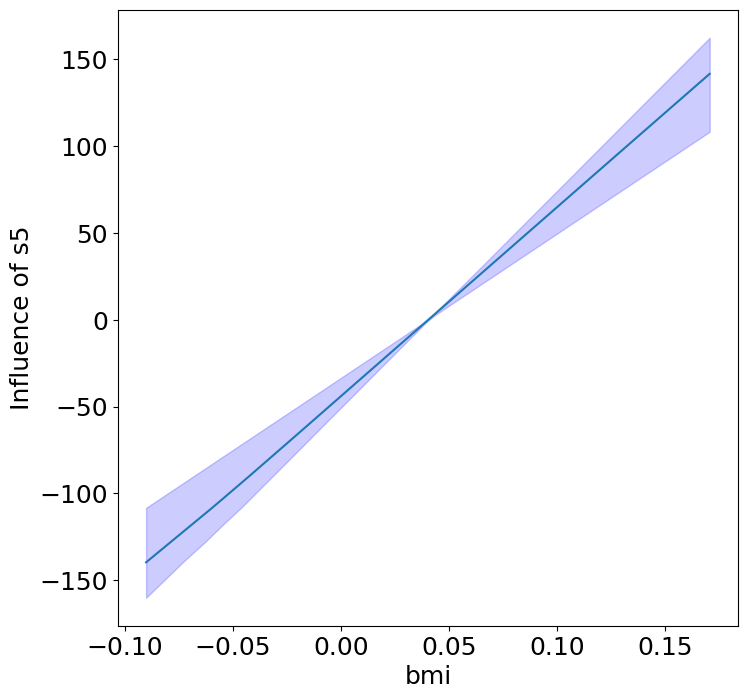

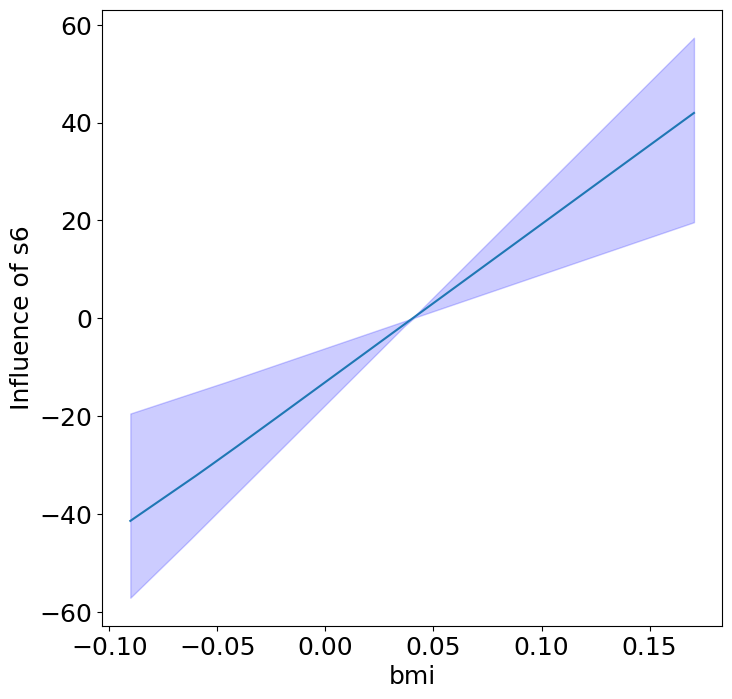

In [17]:
plot_heterogeneous_predictor_effects(model, C, X, min_effect_size=75,
                  ylabel="Influence of")
# Since there are a combinatorial number of heterogeneous predictor effects,
# min_effect_size is a useful parameter to restrict the plotting to
# only the strongest effects.

In [18]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
# This is a combinatorial: context x predictor
heterogeneous_predictor_pvals = calc_heterogeneous_predictor_effects_pvals(model, C)
predictor_pvals = pd.DataFrame(np.array([
   [C.columns[i // len(X.columns)], X.columns[i % len(X.columns)], pval] for i, pval in enumerate(heterogeneous_predictor_pvals.flatten())
]), columns=["Context", "Predictor", "p-value"])

In [19]:
predictor_pvals

,Context,Predictor,p-value
0,age,bp,0.2727272727272727
1,age,s1,0.2727272727272727
2,age,s2,0.2727272727272727
3,age,s3,0.2727272727272727
4,age,s4,0.2727272727272727
5,age,s5,0.2727272727272727
6,age,s6,0.2727272727272727
7,sex,bp,0.09090909090909091
8,sex,s1,0.09090909090909091
9,sex,s2,0.09090909090909091
